<a href="https://colab.research.google.com/github/vpbajaj/CO2_Concentration_RNN/blob/master/C02_Concentration_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("CO2 Concentration")
    plt.grid(True)

Below is the code to read the data file and then plot a graph between the CO2 concentration versus time. 

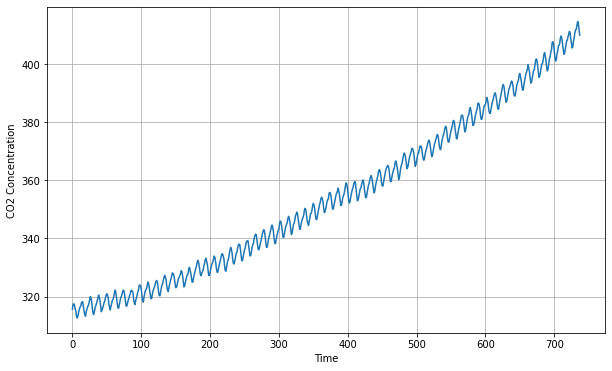

In [3]:
import csv
time_step = []
temps = []

with open('co22.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

We will split the data into a training set and a validation set, then train the model using the training data and test it using the validation data. 

In [0]:
split_time = 700
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 12
batch_size = 32
shuffle_buffer_size = 100


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 12
batch_size = 60
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=12, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 350)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(700,)
Epoch 1/100
12/12 [==============================] - 0s 8ms/step - loss: 363.7425 - mae: 364.2426 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 363.7346 - mae: 364.2346 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 8ms/step - loss: 363.7253 - mae: 364.2253 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 363.7153 - mae: 364.2154 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 363.7047 - mae: 364.2047 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 363.6932 - mae: 364.1933 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 363.6803 - mae: 364.1803 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 363.6651 - mae: 364.1

This is a plot between the loss and the learning rate. The purpose of this plot is to choose the best possible learning rate and re-run the optamization model with this newly chosen learning rate.

(1e-08, 0.01, 0.0, 60.0)

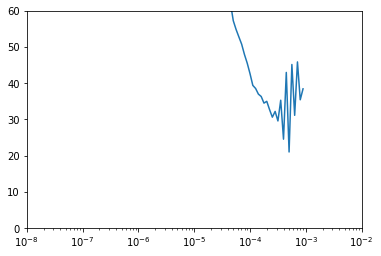

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=24, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=24, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 350)
])


optimizer = tf.keras.optimizers.Adam(lr=2e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=120)

Epoch 1/120
7/7 [==============================] - 0s 8ms/step - loss: 203.8468 - mae: 204.3468
Epoch 2/120
7/7 [==============================] - 0s 10ms/step - loss: 105.6141 - mae: 106.1140
Epoch 3/120
7/7 [==============================] - 0s 12ms/step - loss: 62.4577 - mae: 62.9552
Epoch 4/120
7/7 [==============================] - 0s 14ms/step - loss: 56.2791 - mae: 56.7770
Epoch 5/120
7/7 [==============================] - 0s 11ms/step - loss: 45.8735 - mae: 46.3711
Epoch 6/120
7/7 [==============================] - 0s 11ms/step - loss: 36.9437 - mae: 37.4409
Epoch 7/120
7/7 [==============================] - 0s 12ms/step - loss: 34.3025 - mae: 34.7994
Epoch 8/120
7/7 [==============================] - 0s 10ms/step - loss: 33.1666 - mae: 33.6639
Epoch 9/120
7/7 [==============================] - 0s 11ms/step - loss: 31.7872 - mae: 32.2839
Epoch 10/120
7/7 [==============================] - 0s 10ms/step - loss: 29.8894 - mae: 30.3861
Epoch 11/120
7/7 [============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

This is a plot between CO2 concentration versus time. Only now we are testing the model against the validation dataset.

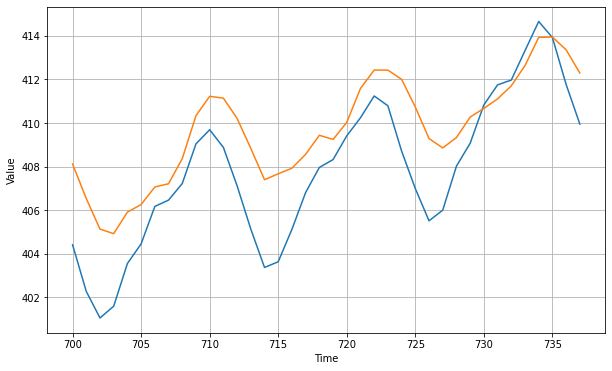

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.017118

In [0]:
print(rnn_forecast)

[408.11557 406.5314  405.1284  404.92133 405.90857 406.25754 407.061
 407.21164 408.36224 410.33395 411.22516 411.1408  410.21234 408.83588
 407.39667 407.66867 407.9242  408.56335 409.43515 409.24567 410.02777
 411.58737 412.42825 412.42795 412.00354 410.73096 409.287   408.8547
 409.3304  410.27148 410.6701  411.10565 411.70572 412.63327 413.93112
 413.94464 413.3588  412.29395]


<Figure size 432x288 with 0 Axes>

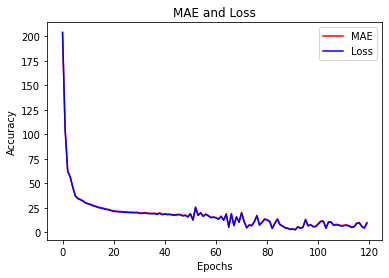

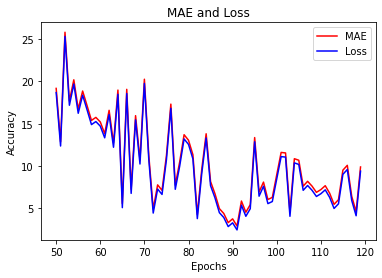

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = mae[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()